# SnapATAC Analysis

Using data processed by Laksshman.

In [ ]:
library(SnapATAC)
library(GenomicRanges)
library(ggplot2) 

# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_snATAC
# https://github.com/r3fang/SnapATAC/tree/master/examples/10X_brain_5k

In [63]:
DAYS = c("D0", "D2", "D4", "D6", "D10", "D12", "D14")
FILE_PREFIX = "/srv/scratch/surag/scATAC-reprog/snap"
BARCODES_PREFIX = "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8"

file.list = c()
barcode.file.list = c()

for (d in DAYS) {
    file.list = c(file.list, sprintf("%s/%s.snap", FILE_PREFIX, d))
    barcode.file.list = c(barcode.file.list, sprintf("%s/%s.barcodes.txt", BARCODES_PREFIX, d))
}
DAYS
file.list
barcode.file.list

[1] "D0"  "D2"  "D4"  "D6"  "D10" "D12" "D14"

[1] "/srv/scratch/surag/scATAC-reprog/snap/D0.snap" 
[2] "/srv/scratch/surag/scATAC-reprog/snap/D2.snap" 
[3] "/srv/scratch/surag/scATAC-reprog/snap/D4.snap" 
[4] "/srv/scratch/surag/scATAC-reprog/snap/D6.snap" 
[5] "/srv/scratch/surag/scATAC-reprog/snap/D10.snap"
[6] "/srv/scratch/surag/scATAC-reprog/snap/D12.snap"
[7] "/srv/scratch/surag/scATAC-reprog/snap/D14.snap"

[1] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D0.barcodes.txt" 
[2] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D2.barcodes.txt" 
[3] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D4.barcodes.txt" 
[4] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D6.barcodes.txt" 
[5] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D10.barcodes.txt"
[6] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D12.barcodes.txt"
[7] "./barcodeLists/20200123_5kb_logcov_gt3_promratio_bw_0.2_0.8/D14.barcodes.txt"

In [64]:
x.sp.ls = lapply(seq(file.list), function(i) {
    x.sp = createSnap(file = file.list[i],                      
                     sample = DAYS[i])
    x.sp
})

Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...
Epoch: reading the barcode session ...


In [65]:
# Filter cells using previously selected barcodes (see BarcodeSelection.ipynb)

barcode.list = lapply(barcode.file.list, function(file){
  read.table(file)[,1];
})
x.sp.list = lapply(seq(x.sp.ls), function(i){
  x.sp = x.sp.ls[[i]];
  x.sp  = x.sp[x.sp@barcode %in% barcode.list[[i]],];
})
names(x.sp.list) = DAYS;

In [66]:
x.sp.list

$D0
number of barcodes: 11150
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D2
number of barcodes: 9817
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D4
number of barcodes: 8763
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D6
number of barcodes: 10612
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D10
number of barcodes: 4118
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D12
number of barcodes: 6358
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0

$D14
number of barcodes: 16434
number of bins: 0
number of genes: 0
number of peaks: 0
number of motifs: 0


In [67]:
x.sp.list = lapply(seq(x.sp.list), function(i) {
    x.sp = addBmatToSnap(x.sp.list[[i]], bin.size=5000, num.cores=5)
    x.sp
})

Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...
Epoch: reading cell-bin count matrix session ...


In [68]:
bin.shared = Reduce(intersect, lapply(x.sp.list, function(x.sp) x.sp@feature$name));

In [69]:
# merge timepoints

x.sp.list <- lapply(x.sp.list, function(x.sp){
    idy = match(bin.shared, x.sp@feature$name);
    x.sp[,idy, mat="bmat"];
  })
x.sp = Reduce(snapRbind, x.sp.list);

In [70]:
x.sp

number of barcodes: 67252
number of bins: 620094
number of genes: 0
number of peaks: 0
number of motifs: 0

In [71]:
rm(x.sp.list); # free memory
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7446800,397.8,10771512,575.3,10771512,575.3
Vcells,4452485350,33969.8,13916280936,106172.8,11310447216,86291.9


In [72]:
x.sp = makeBinary(x.sp, mat="bmat");

In [73]:
tempCov = Matrix::rowSums(x.sp@bmat)

In [74]:
# remove UMIs with few bins
x.sp = x.sp[tempCov>1000, , mat="bmat"]
x.sp

number of barcodes: 66875
number of bins: 620094
number of genes: 0
number of peaks: 0
number of motifs: 0

In [75]:
# sampling few cells for speed (simplified analysis)
# sample_idx = sort(sample(seq(1,dim(x.sp@bmat)[1]), 10000))
# x.sp = x.sp[sample_idx,]
# x.sp

## Filtering bins

In [76]:
black_list = read.table("data/hg38.blacklist.bed.gz");
black_list.gr = GRanges(
    black_list[,1], 
    IRanges(black_list[,2], black_list[,3])
  );

In [77]:
idy = queryHits(findOverlaps(x.sp@feature, black_list.gr));

In [78]:
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};

In [79]:
chr.exclude = seqlevels(x.sp@feature)[grep("random|chrM|chrUn", seqlevels(x.sp@feature))];
idy = grep(paste(chr.exclude, collapse="|"), x.sp@feature);
if(length(idy) > 0){x.sp = x.sp[,-idy, mat="bmat"]};

In [80]:
x.sp

number of barcodes: 66875
number of bins: 617674
number of genes: 0
number of peaks: 0
number of motifs: 0

number of barcodes: 66875
number of bins: 537788
number of genes: 0
number of peaks: 0
number of motifs: 0

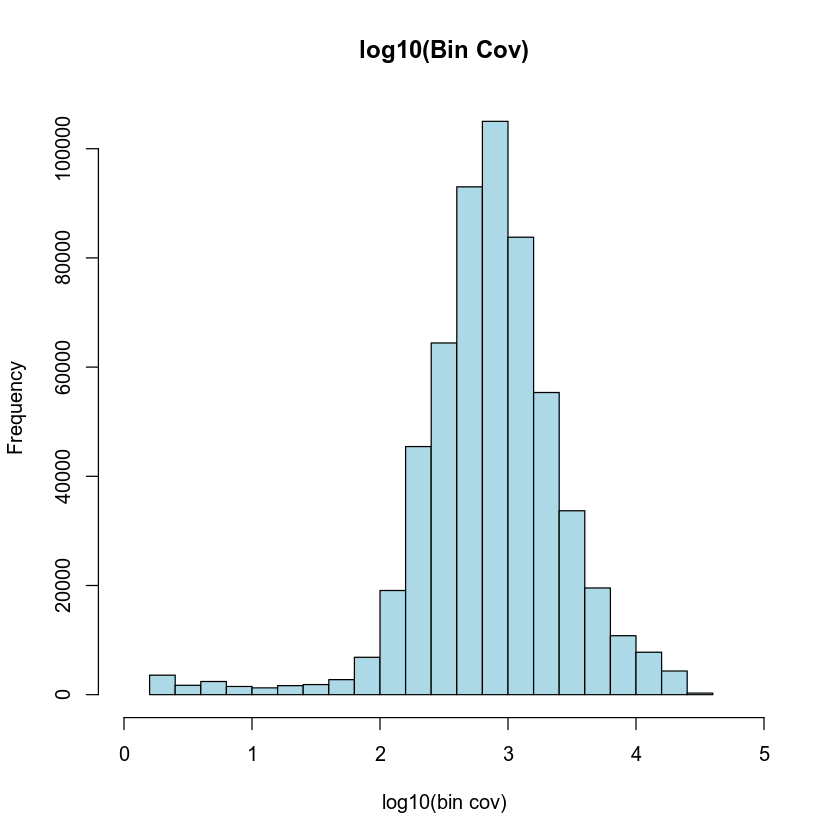

In [81]:
bin.cov = log10(Matrix::colSums(x.sp@bmat)+1);
hist(
  bin.cov[bin.cov > 0], 
  xlab="log10(bin cov)", 
  main="log10(Bin Cov)", 
  col="lightblue", 
  xlim=c(0, 5)
);
bin.cutoff = quantile(bin.cov[bin.cov > 0], 0.95);
idy = which(bin.cov <= bin.cutoff & bin.cov > 0);
x.sp = x.sp[, idy, mat="bmat"];
x.sp

## Dim Reduction

In [82]:
rowCovs = Matrix::rowSums(x.sp@bmat)

In [83]:
row.covs = log10(rowCovs+1);
row.covs.dens = density(
    x = row.covs, 
    bw = 'nrd', adjust = 1
  );
sampling_prob = 1 / (approx(x = row.covs.dens$x, y = row.covs.dens$y, xout = row.covs)$y + .Machine$double.eps); 

In [84]:
set.seed(1);
idx.landmark.ds = sort(sample(x = seq(nrow(x.sp)), size = 10000, prob = sampling_prob));
x.landmark.sp = x.sp[idx.landmark.ds,];
x.query.sp = x.sp[-idx.landmark.ds,];

In [85]:
x.landmark.sp = runDiffusionMaps(
    obj= x.landmark.sp,
    input.mat="bmat", 
    num.eigs=50
);

Epoch: checking the inputs ...
Epoch: computing jaccard similarity matrix ...
Epoch: fitting regression model ...
Epoch: performing normalization ...
Epoch: computing eigen decomposition ...
Epoch: Done


In [86]:
x.query.sp = runDiffusionMapsExtension(
    obj1=x.landmark.sp, 
    obj2=x.query.sp,
    input.mat="bmat"
  );

Epoch: checking the inputs ...
Epoch: computing jaccard similarity matrix ...
Epoch: performing normalization ...
Epoch: projecting query cells to the reference ...
Epoch: Done


In [87]:
x.landmark.sp@metaData$landmark = 1;
x.query.sp@metaData$landmark = 0;
x.sp = snapRbind(x.landmark.sp, x.query.sp);
## combine landmarks and query cells;
x.sp = x.sp[order(x.sp@sample),]; # IMPORTANT
rm(x.landmark.sp, x.query.sp); # free memory

# IMP: recompute since order has changed
rowCovs = Matrix::rowSums(x.sp@bmat)

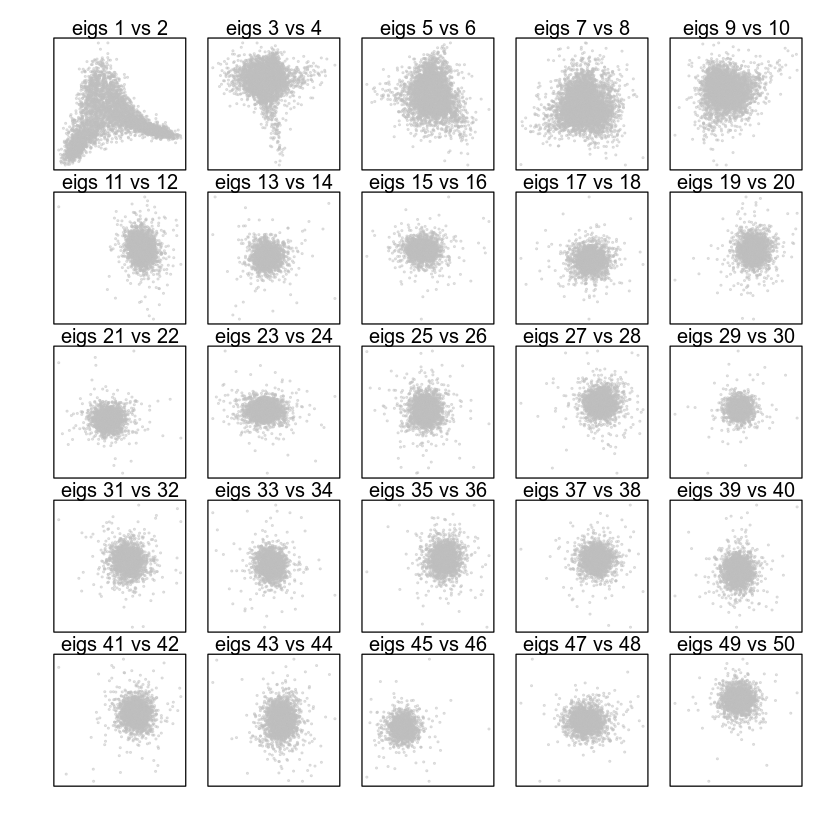

In [90]:
plotDimReductPW(
    obj=x.sp, 
    eigs.dims=1:50,
    point.size=0.3,
    point.color="grey",
    point.shape=19,
    point.alpha=0.6,
    down.sample=5000,
    pdf.file.name=NULL, 
    pdf.height=7, 
    pdf.width=7
  );

In [92]:
x.sp = runKNN(
    obj= x.sp,
    eigs.dim=1:15,
    k=15
  );

In [93]:
library(leiden)

In [94]:
x.sp = runCluster(
   obj=x.sp,
   tmp.folder=tempdir(),
   louvain.lib="leiden",
#    path.to.snaptools=NULL,
   seed.use=10
);
x.sp@metaData$cluster = x.sp@cluster;

In [95]:
table(x.sp@cluster)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
8320 7791 6038 5238 4517 4404 4339 4026 3716 3697 3492 3225 2638 2425 2255  754 

In [ ]:
x.sp = runViz(
    obj=x.sp, 
    tmp.folder=tempdir(),
    dims=2,
    eigs.dims=1:15, 
    method="umap",
    seed.use=10,
    num.cores=10,
  );

In [ ]:
df = data.frame(x.sp@umap, x.sp@sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(shape=".", size=2, alpha=1, aes(x=umap.1 , y=umap.2, col=x.sp.sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) +
ggsave(sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_wD28_n%d_UMAP_day.pdf", 
               format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1]))

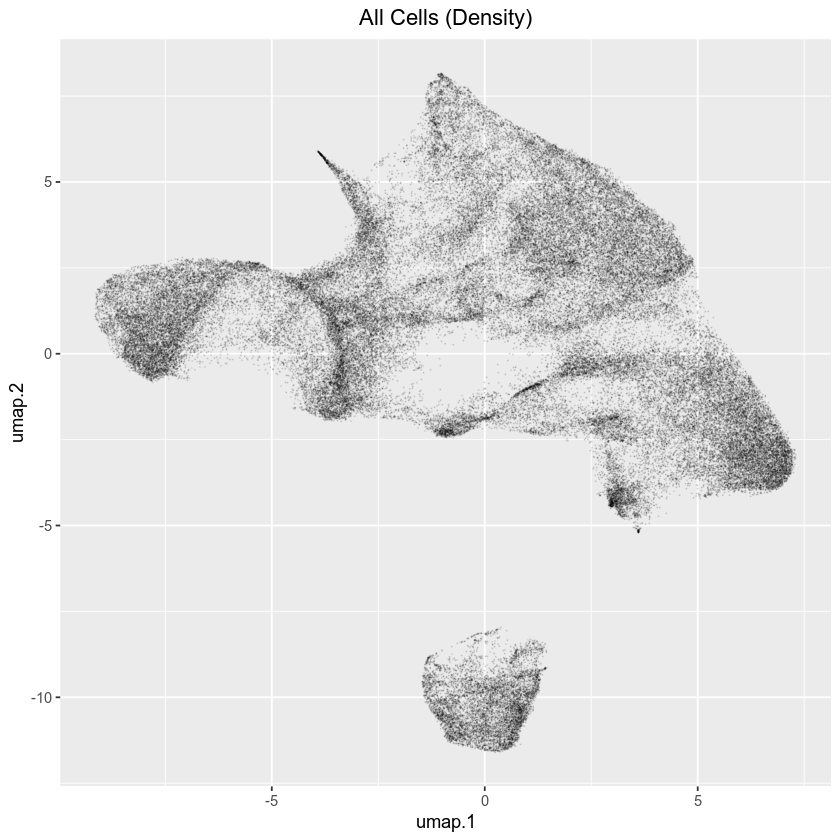

In [173]:
df = data.frame(x.sp@umap, x.sp@sample)

ggplot(df) +
geom_point(shape=20, size=0.05, alpha=0.1, aes(x=umap.1 , y=umap.2)) +
ggtitle("All Cells (Density)") + 
theme(plot.title = element_text(hjust = 0.5)) 

In [148]:
library(RColorBrewer)

In [153]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

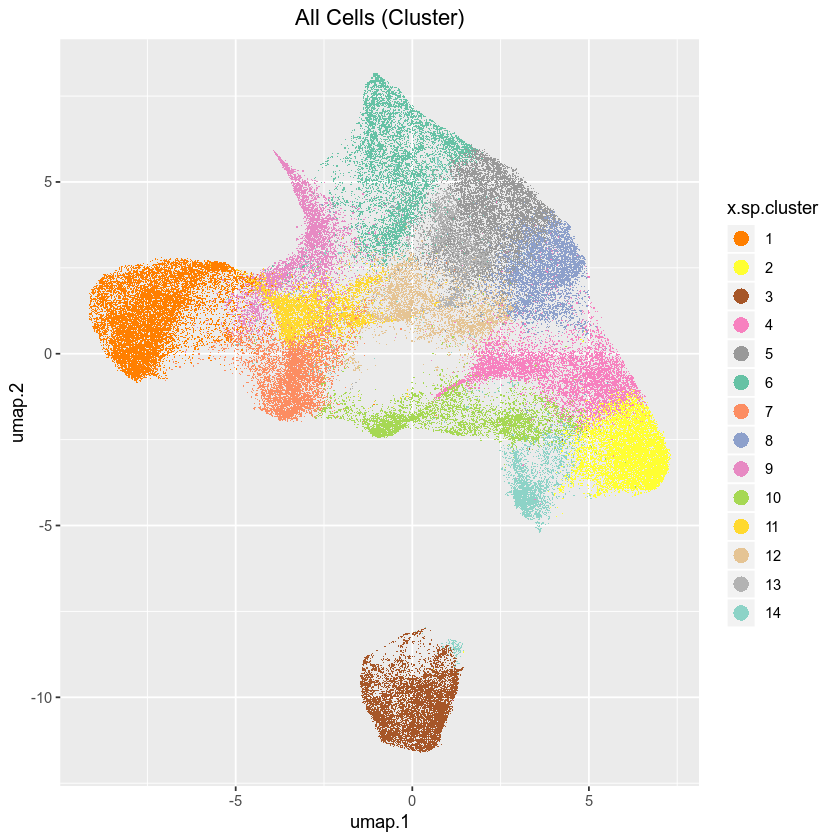

In [179]:
df = data.frame(x.sp@umap, x.sp@cluster)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=x.sp.cluster)) +
geom_point(shape=".", size=2, alpha=1) +
scale_colour_manual(values = col_vector[seq(50,63)]) +
ggtitle("All Cells (Cluster)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [189]:
head(df)

,umap.1,umap.2,promoter_ratio
AACTCGATGTCTGTGA,-5.776760,2.2785701,0.06505364
ACTCCAGCTCCTCCTA,5.628437,-2.7295815,0.06184971
ACACTCCACTGGGCCT,-8.604280,1.1090138,0.05925682
X.4523,2.455998,-0.5606213,0.05366492
TGGCATCCTACCAGTT,1.209242,-9.0863865,0.08044713
TAGTCGCCTGAGAGGG,2.612640,1.4179731,0.05268208


In [ ]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
prom.hg38 = promoters(genes(txdb), upstream = 2000, downstream = 0)
overlaps = findOverlaps(x.sp@feature, prom.hg38);
idy = queryHits(overlaps)
promoter_ratio = Matrix::rowSums(x.sp@bmat[,idy]) / Matrix::rowSums(x.sp@bmat);

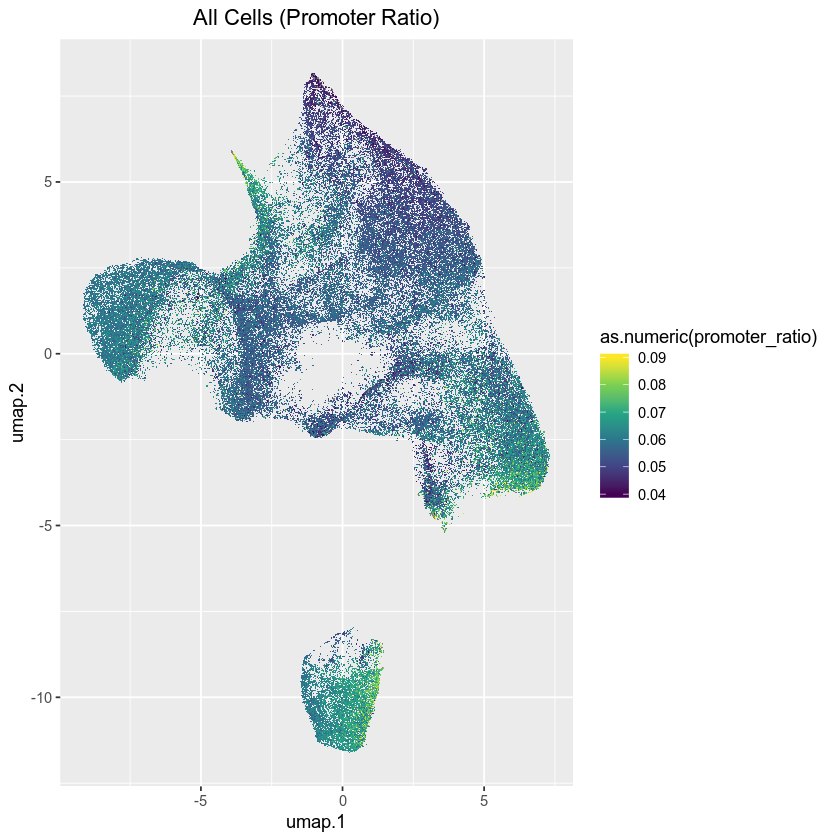

In [211]:
df = data.frame(x.sp@umap, promoter_ratio)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=as.numeric(promoter_ratio))) +
geom_point(shape=".", alpha=1) +
scale_color_viridis_c(lim=c(0.04,0.09)) +
ggtitle("All Cells (Promoter Ratio)") + 
theme(plot.title = element_text(hjust = 0.5)) 

#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])

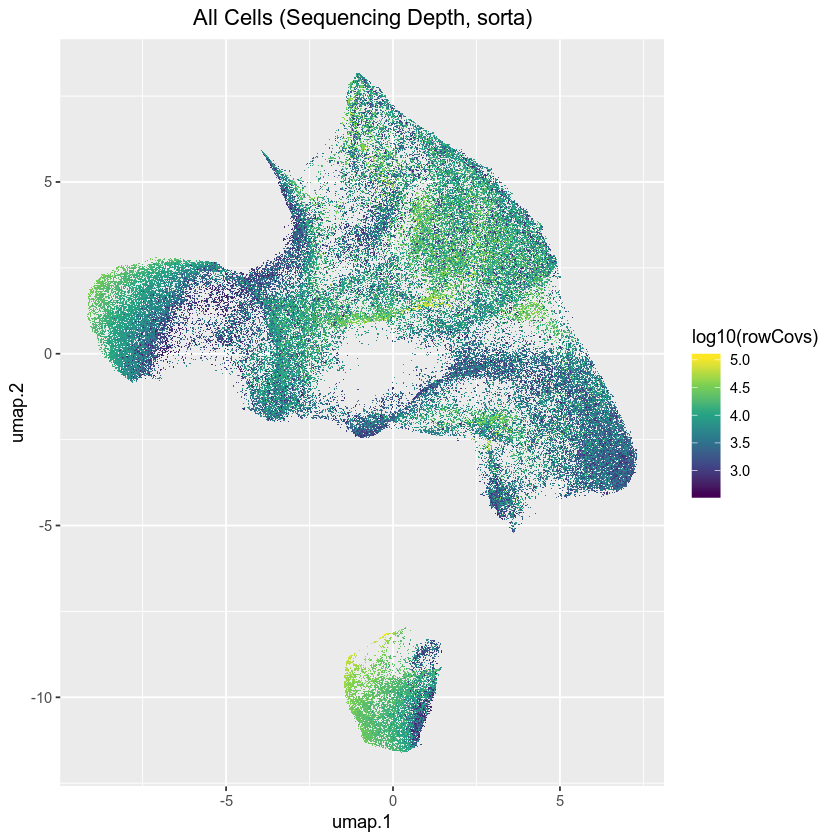

In [212]:
df = data.frame(x.sp@umap, rowCovs)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df, aes(x=umap.1, y=umap.2, col=log10(rowCovs))) +
geom_point(shape=".", alpha=1) +
scale_color_viridis_c() +
ggtitle("All Cells (Sequencing Depth, sorta)") + 
theme(plot.title = element_text(hjust = 0.5)) 

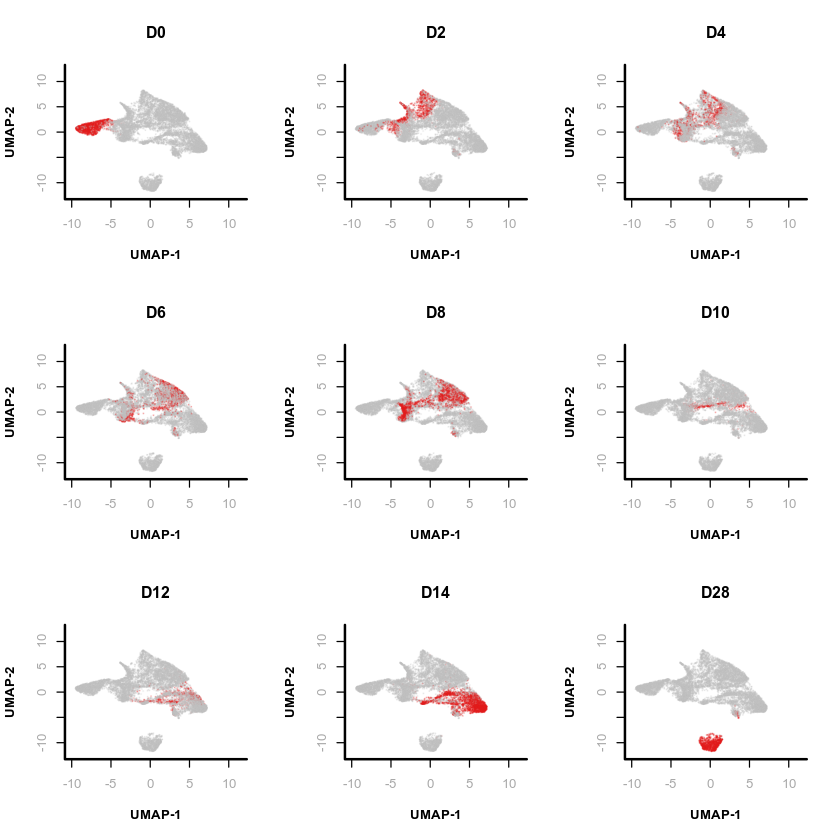

In [89]:
par(mfrow = c(3, 3));
for(d in DAYS){
  plotViz(
    obj=x.sp,
    method="umap", 
    main=d,
    point.color=x.sp@sample==d, 
    point.size=0.01,
    point.alpha=0.2,
    text.add= FALSE,
    down.sample=10000,
    legend.add=FALSE,
#     pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_day", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  );
}

In [138]:
table(x.sp@sample[x.sp@cluster=="14"])


  D0  D10  D12  D14   D2  D28   D4   D6   D8 
  17   80  344 1514  228  300  183  268  207 

In [172]:
plotFeatureSingle(
    obj=x.sp,
    feature.value=log10(rowCovs),
    method="umap", 
    main="By depth",
    point.size=0.1, 
    point.shape=19, 
    down.sample=NULL,
    quantiles=c(0.01, 0.99),
    pdf.file.name = sprintf("./figs/%s_5kb_selectedBarcodes_gt1000_n%d_UMAP_depth.pdf", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
  ); 

png 
  2

In [ ]:
# x.sp = runViz(
#     obj=x.sp, 
#     tmp.folder=tempdir(),
#     dims=2,
#     eigs.dims=1:18, 
#     method="Rtsne",
#     seed.use=10,
#     num.cores=10
#   );

In [ ]:
# plotViz(
#     obj=x.sp,
#     method="tsne", 
#     main="All Cells",
#     point.color=x.sp@sample, 
#     point.size=0.1, 
#     text.add= FALSE,
#     down.sample=NULL,
#     legend.add=TRUE,
# #     pdf.file.name = sprintf("./figs/%s_5kb_gt1000_n%d_TSNE.pdf", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
#   );

In [ ]:
# plotFeatureSingle(
#     obj=x.sp,
#     feature.value=log10(rowCovs),
#     method="tsne", 
#     main="By depth",
#     point.size=0.1, 
#     point.shape=19, 
#     down.sample=NULL,
#     quantiles=c(0.01, 0.99)
#   ); 

In [54]:
# library(harmony)
# x.after.sp = runHarmony(
#   obj=x.sp, 
#   eigs.dim=1:18, 
#   meta_data=x.sp@sample # sample index
# );

In [55]:
# x.after.sp = runViz(
#    obj=x.after.sp, 
#    tmp.folder=tempdir(),
#    dims=2,
#    eigs.dims=1:18, 
#    method="umap",
#    seed.use=10
#  );

In [56]:
# plotViz(
#     obj=x.after.sp,
#     method="umap", 
#     main="All Cells (After Harmony)",
#     point.color=x.sp@sample, 
#     point.size=0.5, 
#     text.add= FALSE,
#     down.sample=10000,
#     legend.add=TRUE,
# #     pdf.file.name = sprintf("./figs/%s_5kb_gt1000_n%d_UMAP_harmony_sample", format(Sys.Date(), "%Y%m%d"), dim(x.sp@bmat)[1])
#   );

In [ ]:
# re-add non-binarized cell-by-bin matrix
x.sp.raw = addBmatToSnap(x.sp);

Epoch: reading cell-bin count matrix session ...


In [ ]:
x.sp.raw

In [174]:
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb = TxDb.Hsapiens.UCSC.hg38.knownGene
genes.hg38 = genes(txdb)

In [ ]:
genes(txdb, columns="gene_id")

In [175]:
marker.genes = c(
    2597, #"GAPDH"
    7070, # THY1
    3725, # "JUN" 
    5460, # "OCT4"
    79923, # "NANOG"
    2103, # "ESRRB"
    57167, #SALL4
    2335, #"FN1"
    7431, #"VIM"
    58, #"ACTA1"
    7015, #"TERT"
    429 #"ASCL1"
)

marker.genes.names = c(
    "GAPDH",
    "THY1",
    "JUN",
    "OCT4",
    "NANOG",
    "ESRRB",
    "SALL4",
    "FN1",
    "VIM",
    "ACTA1",
    "TERT",
    "ASCL1"
)

In [ ]:
# use promoters of genes
genes.sel.gr = promoters(genes.hg38[genes.hg38$gene_id %in% marker.genes], upstream = 2000, downstream = 0)
genes.sel.gr$name = marker.genes.names[order(as.character(marker.genes))]
genes.sel.gr
# CHECK ID AND NAME LINE UP

In [159]:
x.sp.raw = createGmatFromMat(
    obj=x.sp.raw, 
    input.mat="bmat",
    genes=genes.sel.gr,
    do.par=TRUE,
    num.cores=10
);

In [157]:
# normalize the cell-by-gene matrix
x.sp.raw = scaleCountMatrix(
  obj=x.sp.raw, 
  cov=rowCovs, # TODO: check if this is the right input
  mat="gmat",
  method = "RPM"
);

# smooth the cell-by-gene matrix
# raises knn similarity matrix to 3-- VERY SLOW 


In [147]:
myRunMagic <- function (obj, input.mat, step.size) {
    A = obj@graph@mat;
    data.use = obj@gmat;
    # 4. smooth
    A = A + t(A);
    A = A / Matrix::rowSums(A);
    data.use.smooth = A %*% data.use;
    if(step.size > 1){
        for(i in 1:step.size){
            data.use.smooth = A %*% data.use.smooth;
        }
    }
    
    slot(obj, input.mat) = data.use.smooth;    
    return(obj)
}

In [162]:
# x.sp = myRunMagic(
#   obj=x.sp,
#   input.mat="gmat",
#   step.size=1
# );

x.sp.raw = myRunMagic(
  obj=x.sp.raw,
  input.mat="gmat",
  step.size=8
);

In [ ]:
# par(mfrow = c(3, 3));
for(i in 1:length(marker.genes)){
  plotFeatureSingle(
      obj=x.sp.raw,
      feature.value=x.sp.raw@gmat[, marker.genes.names[i]],
      method="umap", 
      main=marker.genes.names[i],
      point.size=0.01, 
      point.shape=19, 
      down.sample=NULL,
      quantiles=c(0, 1)
)};



## Write Fragment for each cluster

In [290]:
writeClusterFragmentsToBed <- function(
    obj, 
    output.prefix,
    path.to.snaptools,
    buffer.size=500,
    num.cores=10
){
    fileList = as.list(unique(obj@file));
 
    # check if files are all snap files
    if(any(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){isSnapFile(x)})) == FALSE)
        print("error: these files are not snap file")
        print(fileList[idx])
        stop()
    }
    
    # check if FM session exist
    if(any(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)){
        idx = which(do.call(c, lapply(fileList, function(x){ "FM" %in% h5ls(x, recursive=1)$name  })) == FALSE)
        print("error: the following nsap files do not contain FM session")
        print(fileList[idx])
        stop()
    }
        
    # write the following barcodes down
    barcode.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".barcode.txt");
    })

    bed.files = lapply(fileList, function(file){
        tempfile(tmpdir = tempdir(), fileext = ".bed.gz");
    })
    
    # write down the barcodes
    cat("Epoch: extracting fragments from each snap files ...\n", file = stderr())
    flag.list = lapply(seq(fileList), function(i){
        file.name = fileList[[i]];
        idx = which(obj@file == file.name);
        barcode.use = obj@barcode[idx]
        message(barcode.files[[i]])
        message(bed.files[[i]])
        message(fileList[[i]])
        write.table(barcode.use, file = barcode.files[[i]], append = FALSE, quote = FALSE, sep = "\t",
                         eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                         col.names = FALSE, qmethod = c("escape", "double"),
                         fileEncoding = "")
        
    })

    # extract the fragments belong to the barcodes    
    flag.list = mclapply(seq(fileList), function(i){
        flag = system2(command=path.to.snaptools, 
            args=c("dump-fragment", 
                   "--snap-file", fileList[[i]], 
                   "--output-file", bed.files[[i]], 
                   "--barcode-file", barcode.files[[i]],
                   "--buffer-size", buffer.size
                   )        
            )                
    }, mc.cores=num.cores);
    
    # combine these bed files
    combined.bed = paste(output.prefix, ".bed.gz");
    flag = system2(command="cat", 
        args=c(paste(bed.files, collapse = ' '),
               ">", combined.bed
               )        
        )                
}

In [ ]:
cluster_names = names(table(x.sp@cluster))
# mclapply(seq(cluster_names), function(i){
#     print(cluster_names[i]);
#     writeClusterFragmentsToBed(
#         obj=x.sp[which(x.sp@cluster==cluster_names[i]),], 
#         output.prefix=paste0("./snapATAC_sessions/20200125_n76770/cluster_beds/idx", cluster_names[i]),
#         path.to.snaptools="/users/surag/anaconda3/envs/snapATAC/bin/snaptools",
#         buffer.size=500, 
#         num.cores=1
#    );
#  }, mc.cores=5);

In [ ]:
temp

## Export Meta Data for Session

In [263]:
myExportMetaData <- function(obj, file, slot.names) {
    metaData.ls = lapply(as.list(slot.names), function(x){
        if(x == "barcode"){
            y = data.frame(slot(obj, x));
            colnames(y) = "barcode"
        }else if(x == "tsne"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("tsne1", "tsne2");
        }else if(x == "umap"){
            y = data.frame(slot(obj, x));
            colnames(y) = c("umap1", "umap2");
        }else if(x == "cluster"){
            y = data.frame(slot(obj, x));
            colnames(y) = "cluster"
        }else if(x == "sample"){
            y = data.frame(slot(obj, x));
            colnames(y) = "sample"
        }else{
            y = data.frame(slot(obj, x));
        }
        y
    })
    
    if(!all(sapply(lapply(metaData.ls, nrow), FUN = identical, nrow(metaData.ls[[1]])))){
        stop("slot in subset.names have different length")
    }
    
    metaData.df = do.call(cbind, metaData.ls);

    write.table(metaData.df, file = file, append = FALSE, quote = FALSE, sep = "\t",
                eol = "\n", na = "NA", dec = ".", row.names = FALSE,
                col.names = TRUE, qmethod = c("escape", "double"),
                fileEncoding = "")
}

myExportMetaData(x.sp, "./snapATAC_sessions/20200125_n76770/metadata.tsv", slot.names=c('barcode', 'cluster', 'umap', 'metaData', 'sample'))

In [53]:
write.table(x.sp@smat@dmat, "./snapATAC_sessions/20200125_n76770/eig_mat.tsv", sep="\t", row.names= FALSE, col.names = FALSE, quote = FALSE)

In [74]:
# writing ranges for 5kb and sparse matrix
write.table(data.frame(seqnames=seqnames(x.sp@feature),
                       starts=start(x.sp@feature)-1,
                       ends=end(x.sp@feature)),
            file="./snapATAC_sessions/20200125_n76770/5kb.ranges.bed",
            quote=F, sep="\t", row.names=F, col.names=F)

In [16]:
writeMM(x.sp@bmat, file="./snapATAC_sessions/20200125_n76770/5kb.sparse.mm")

NULL

In [ ]:
# How to get the order in which a list A can be transformed to a list B 
# When both have same unique elements in them
# o(A)   o(B) o(o(B))   o(A)[o(o(B))] <---- that's what you need to do
# 3   ->  4     3           2
# 4   ->  2     2           4 
# 2   ->  1     4           1
# 1   ->  3     1           3

In [32]:
# metaData = read.table("./snapATAC_sessions/20200125_n76770/metadata.tsv", header = T)
# metaData$sample_barcode = paste(as.character(metaData$sample), as.character(metaData$barcode), sep='_')

In [ ]:
# actual_sample_barcode = paste(x.sp.raw@sample, x.sp.raw@barcode, sep="_")

In [ ]:
# sort_order = order(actual_sample_barcode)[order(order(metaData$sample_barcode))]

In [ ]:
# all(actual_sample_barcode[sort_order] == metaData$sample_barcode)

In [42]:
# writeMM(x.sp.raw@bmat[sort_order, ], file="./snapATAC_sessions/20200125_n76770/5kb.full.mm")

NULL